In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import hbar
from sympy import Matrix
from scipy.integrate import solve_ivp
from arc.alkali_atom_functions import AlkaliAtom
import arc
import qutip

paper for this document: https://arxiv.org/pdf/2205.14621.pdf

https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.105.193603



paper to read:
https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.129.160501

# Simulation of two rubidium87 interacting atoms.

Three levels of each atroms are considered: ground, 6p and 70s. So the hilbert space dimension will be 9.

The atoms are indipendently coupled by two lasers, one will be on resonance, one out of resonance.

$$ H_0 = 
\begin{pmatrix}
    0 & \Omega_b & 0 \\
    \Omega_b & -\Delta & \Omega_{IR} \\
    0 & \Omega_{IR} & -\delta 
\end{pmatrix}
$$
where $\Delta$ is the detuning from the intermediate state and $\delta$ is the detuning from the rydberg.

$$ H_{int} = 
\begin{pmatrix}
    0 & 0 & 0 \\
    0 & 0 & 0 \\
    0 & 0 & 1 \\
\end{pmatrix} \otimes
\begin{pmatrix}
    0 & 0 & 0 \\
    0 & 0 & 0 \\
    0 & 0 & 1 \\
\end{pmatrix} = 
\begin{pmatrix}
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{pmatrix}
$$

$$ H_{tot} = I \otimes H_0 + H_0 \otimes I + H_{int} $$


    
The interaction is modilized ad a shifting of the |rr> level (r="rydberg").

In [2]:

def sigma(a, b): # |a><b| operator
    basis_a = [
        np.array([[1],[0],[0]]),
        np.array([[0],[1],[0]]),
        np.array([[0],[0],[1]])
    ]
    basis_b = [
        np.array([1,0,0]),
        np.array([0,1,0]),
        np.array([0,0,1])
    ]
    return np.kron(basis_a[a],basis_b[b])

def H_0(Omega_b, Omega_IR, Delta, delta):
    dressed_H = np.array([[0, Omega_b, 0],[Omega_b, -Delta, Omega_IR],[0, Omega_IR, -delta]])
    return dressed_H

def H_int(V_fac): # V_fac = C_6 / r^6
    return V_fac*np.kron(sigma(2,2), sigma(2,2))

def lindblad_term(jump_operator, rho):
    return (np.dot(jump_operator,rho).dot(jump_operator.transpose().conjugate())-
        (np.dot(jump_operator.transpose().conjugate(),jump_operator).dot(rho)+
        np.dot(rho,jump_operator.transpose().conjugate()).dot(jump_operator))/2)

def rho_dot(H, rho, jump_ops = []):
    environment_interaction = np.zeros(rho.shape, dtype=complex)
    for jump_op in jump_ops:
        environment_interaction += lindblad_term(jump_op, rho)
    return -1j*(np.dot(H,rho)-np.dot(rho,H))+environment_interaction

def evolution(initial_state, H, steps, dt, jump_ops = []):
    state = initial_state
    state_evolution = [state]
    for i in range(steps):
        state = state + rho_dot(H, state, jump_ops)*dt
        state_evolution.append(state)
    return state_evolution

In [3]:
atom=arc.Rubidium87()
# transition from 5s1/2 to 6p3/2
O5s_6p = atom.getRabiFrequency(n1=5,  l1=0, j1=0.5, mj1=0.5,  n2=6,  l2=1, j2=3/2, q=0, laserPower=1.5*10**(-3), laserWaist=40*10**(-6), s=0.5)
                           ### n1, l1,  j1, mj1, n2, l2,  j2,  q,   laserPower,  laserWaist, s=0.5 
print("omega/2pi =", "{:e}".format(O5s_6p/(2*np.pi)))
print("omega =", "{:e}".format(O5s_6p)) 

# transition from 6p3/2 to 70s1/2
O6p_70s = atom.getRabiFrequency(n1=70,  l1=0, j1=0.5, mj1=0.5,  n2=6,  l2=1, j2=3/2, q=0, laserPower=48.2*10**(-3), laserWaist=200*10**(-6), s=0.5)
                           ### n1, l1,  j1, mj1, n2, l2,  j2,  q,   laserPower,  laserWaist, s=0.5 
print("omega/2pi =", "{:e}".format(O6p_70s/(2*np.pi)))
print("omega =", "{:e}".format(O6p_70s))

Delta = 200*10**6
print("two_photon_rabi_freq = ", "{:e}".format((O6p_70s/(2*np.pi)*O5s_6p/(2*np.pi))/(2*Delta)))

omega/2pi = 5.992846e+07
omega = 3.765416e+08
omega/2pi = 2.266966e+06
omega = 1.424377e+07
two_photon_rabi_freq =  3.396395e+05


In [16]:
t = 10
steps = 100000
dt = t/steps
rho_0 = np.kron(sigma(0,0), sigma(0,0))
N_states = 3

two_ph_r_f = 0.2

Delta = 200
delta = 0
Om_b = 6/2 #np.sqrt(two_ph_r_f*2*Delta) #O5s_6p/(2*np.pi)*10**-6 # 10
Om_IR = 2.2 #np.sqrt(two_ph_r_f*2*Delta) #5 #O6p_70s/(2*np.pi)*10**-6 # 3
V_f = 10
Gamma_6p = 8
Gamma_70s = 0.02 # 0 # 0.02

Na = {"interacting": {"0": 0, "1": 0, "2": 0}, "not_interacting": {"0": 0, "1": 0, "2": 0}}
Nb = {"interacting": {"0": 0, "1": 0, "2": 0}, "not_interacting": {"0": 0, "1": 0, "2": 0}}

S_minus_6p = Gamma_6p**(1/2)*np.array([[0,1,0],[0,0,0],[0,0,0]])
S_minus_70s = Gamma_70s**(1/2)*np.array([[0,0,0],[0,0,1],[0,0,0]])
Jump_ops = [np.kron(S_minus_6p, np.eye(3)), np.kron(np.eye(3), S_minus_6p), np.kron(S_minus_70s, np.eye(3)), np.kron(np.eye(3), S_minus_70s)]
H = np.kron(H_0(Om_b, Om_IR, Delta, 0), np.eye(3)) + np.kron(np.eye(3), H_0(Om_b, Om_IR, Delta, delta))
Hs = [H, H+H_int(V_f)]
labels = ["not_interacting", "interacting"]

for i, H in enumerate(Hs):
    evo = evolution(rho_0, H, steps, dt, Jump_ops)
    label = labels[i]
    for l in range(N_states):
        Nb[labels[i]]["%d"%l] = [np.trace(np.dot(evo[i],np.kron(np.eye(3),sigma(l,l)))) for i in range(steps+1)]
        Na[labels[i]]["%d"%l] = [np.trace(np.dot(evo[i],np.kron(sigma(l,l),np.eye(3)))) for i in range(steps+1)]
times = np.linspace(0,dt*(steps+1), steps+1)

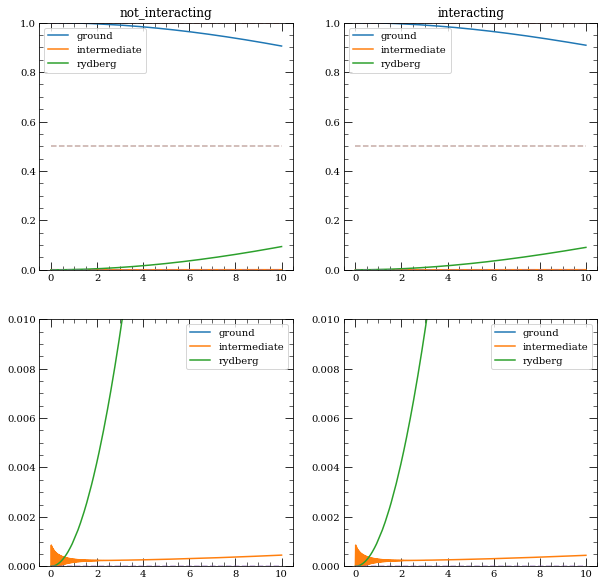

In [17]:
labels_ = ["ground","intermediate","rydberg"]
plt.figure(figsize=(10,10))

for i, label in enumerate(labels):
    plt.subplot(2,2,i+1)
    for j in range(N_states):
        plt.plot(times, Nb[label]["%d"%j], label=labels_[j])
    plt.plot([0,times[-1]],[1,1],"--", alpha=0.5)
    plt.plot([0,times[-1]],[0,0],"--", alpha=0.5)
    plt.plot([0,times[-1]],[1/2,1/2],"--", alpha=0.5)
    plt.ylim([0,1])
    plt.title(label)
    plt.legend()

    plt.subplot(2,2,i+3)
    for j in range(N_states):
        plt.plot(times, Na[label]["%d"%j], label=labels_[j])
    plt.plot([0,times[-1]],[1,1],"--", alpha=0.5)
    plt.plot([0,times[-1]],[0,0],"--", alpha=0.5)
    plt.plot([0,times[-1]],[1/2,1/2],"--", alpha=0.5)
    plt.ylim([0,0.01])
    #plt.xlim([0,1])
    plt.legend()
plt.show()

In [6]:
0.005*20000*4/10


40.0

NameError: name 'Na00' is not defined

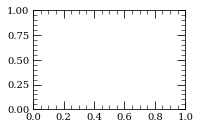

In [7]:

plt.subplot(223)

plt.plot(times, Na00, label="Na00")
plt.plot(times, Na11, label="Na11")
plt.plot(times, Na22, label="Na22")
plt.plot([0,times[-1]],[1,1],"--", alpha=0.5)
plt.plot([0,times[-1]],[0,0],"--", alpha=0.5)
plt.plot([0,times[-1]],[1/2,1/2],"--", alpha=0.5)
plt.ylim([0,1])
plt.legend()

plt.subplot(222)

plt.plot(times, Nb00, label="Nb00")
plt.plot(times, Nb11, label="Nb11")
plt.plot(times, Nb22, label="Nb22")
plt.plot([0,times[-1]],[1,1],"--", alpha=0.5)
plt.plot([0,times[-1]],[0,0],"--", alpha=0.5)
plt.plot([0,times[-1]],[1/2,1/2],"--", alpha=0.5)
plt.ylim([0,1])
plt.legend()

plt.subplot(224)

plt.plot(times, Na00, label="Na00")
plt.plot(times, Na11, label="Na11")
plt.plot(times, Na22, label="Na22")
plt.plot([0,times[-1]],[1,1],"--", alpha=0.5)
plt.plot([0,times[-1]],[0,0],"--", alpha=0.5)
plt.plot([0,times[-1]],[1/2,1/2],"--", alpha=0.5)
plt.ylim([0,1])
plt.legend()

plt.show()

changing the detuning

In [ ]:
t = 10
steps = 100
dt = t/steps
rho_0 = np.kron(sigma(0,0), sigma(0,0))
GammaA = np.array([[1,1,1],[1,1,1],[1,1,1]])
GammaB = np.array([[1,1,1],[1,1,1],[1,1,1]])
Om_p = 1
Om = 1
Om_c = 1
Vab = 1

Nb = {"00":[],"11":[],"22":[]}
Na = {"00":[],"11":[],"22":[]}

values_delta_c = np.arange(0,-16, step=-2)
print(values_delta_c)

for Delta_c in values_delta_c:
    H = H_a(Om_p, Om) + H_b(Om_c, Delta_c) + H_int(Vab)
    evo = evolution(steps, dt, rho_0, H, GammaA, GammaB)

    Nb["00"].append(np.trace(np.dot(evo[-1],np.kron(np.eye(3),sigma(0,0)))))
    Nb["11"].append(np.trace(np.dot(evo[-1],np.kron(np.eye(3),sigma(1,1)))))
    Nb["22"].append(np.trace(np.dot(evo[-1],np.kron(np.eye(3),sigma(2,2)))))

    Na["00"].append(np.trace(np.dot(evo[-1],np.kron(sigma(0,0),np.eye(3)))))
    Na["11"].append(np.trace(np.dot(evo[-1],np.kron(sigma(1,1),np.eye(3)))))
    Na["22"].append(np.trace(np.dot(evo[-1],np.kron(sigma(2,2),np.eye(3)))))

[  0  -2  -4  -6  -8 -10 -12 -14]


NameError: name 'H_a' is not defined

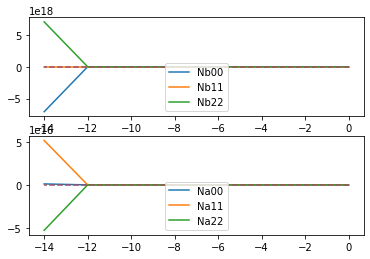

In [ ]:
plt.subplot(211)

plt.plot(values_delta_c, Nb["00"], label="Nb00")
plt.plot(values_delta_c, Nb["11"], label="Nb11")
plt.plot(values_delta_c, Nb["22"], label="Nb22")
plt.plot([0,values_delta_c[-1]],[1,1],"--", alpha=0.5)
plt.plot([0,values_delta_c[-1]],[0,0],"--", alpha=0.5)
plt.plot([0,values_delta_c[-1]],[1/2,1/2],"--", alpha=0.5)
plt.legend()

plt.subplot(212)

plt.plot(values_delta_c, Na["00"], label="Na00")
plt.plot(values_delta_c, Na["11"], label="Na11")
plt.plot(values_delta_c, Na["22"], label="Na22")
plt.plot([0,values_delta_c[-1]],[1,1],"--", alpha=0.5)
plt.plot([0,values_delta_c[-1]],[0,0],"--", alpha=0.5)
plt.plot([0,values_delta_c[-1]],[1/2,1/2],"--", alpha=0.5)
plt.legend()

plt.show()